In [1]:
#Import libraries
from utils import downloadFromUrl

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

In [111]:
URL_DATA = "https://tspace.library.utoronto.ca/bitstream/1807/10398/1/DobeHtWt-corrected.csv"
FILE_DATA = "DobeHtWt-corrected.csv"

# Download and read the data
downloadFromUrl(URL_DATA)
howell_df = pd.read_csv(FILE_DATA)

In [112]:
# Data cleansing and feature engineering
# Getting only data with heights and weights
howell_df = howell_df[["htcms", "wghtlbs", "sex26", "yearbir", "obsyr4"]]
howell_df['age'] = howell_df['obsyr4'] - howell_df['yearbir']
howell_df.drop(columns=['obsyr4', 'yearbir'], inplace=True)
howell_df['sex26'] = pd.np.where(howell_df['sex26'] == "male", 1, 0)
howell_df.columns = ['height', 'weight', 'male', 'age']

# "height" and "weight" must contain numbers
howell_df = howell_df[
    (howell_df['height'].str.contains('[0-9]+\.[0-9]', regex=True)) &
    (howell_df['weight'].str.contains('[0-9]+', regex=True))
    ]
howell_df['height'] = howell_df['height'].astype(float)
howell_df['weight'] = howell_df['weight'].apply(float)

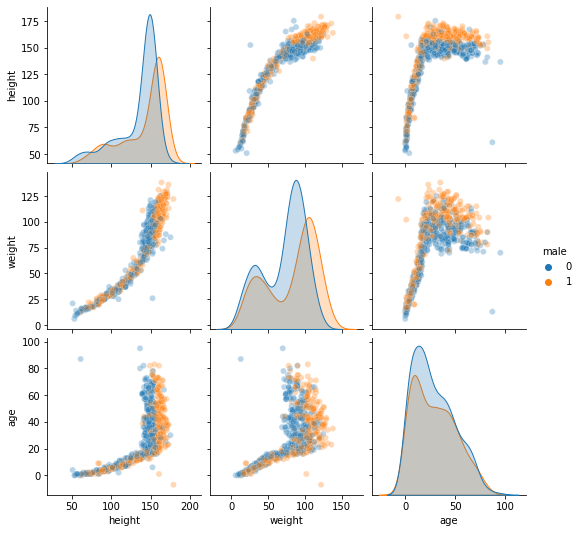

In [4]:
# Exploring the relationship between variables
sns.pairplot(howell_df, hue="male", plot_kws=dict(alpha=0.3));

In [113]:
# Data transformation:
# 1. Apply log to height (distribution of target in glm)
# 2. One hot encoding age in two buckets (below and above 22)
howell_df["height"] = howell_df["height"].apply(np.log)

ohe_age = pd.get_dummies(howell_df["age"]>22)
ohe_age[False] *= howell_df["age"]
ohe_age[True] *= howell_df["age"]
ohe_age.columns = ["young", "old"]
howell_df.drop(columns="age", inplace=True)
howell_df = howell_df.join(ohe_age)

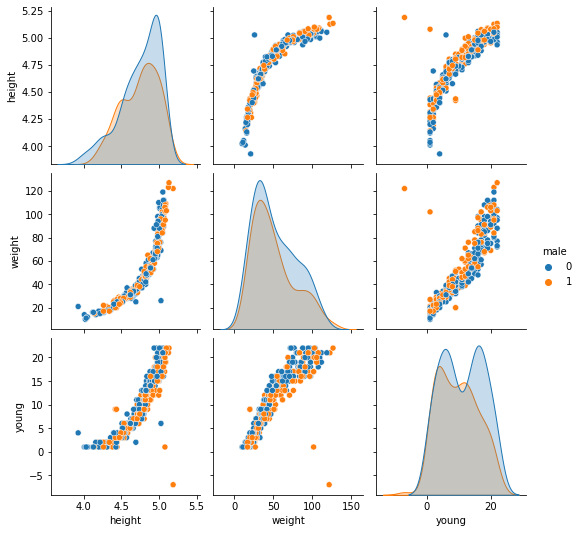

In [6]:
sns.pairplot(howell_df[howell_df['young']!=0].drop(columns="old"), hue="male");

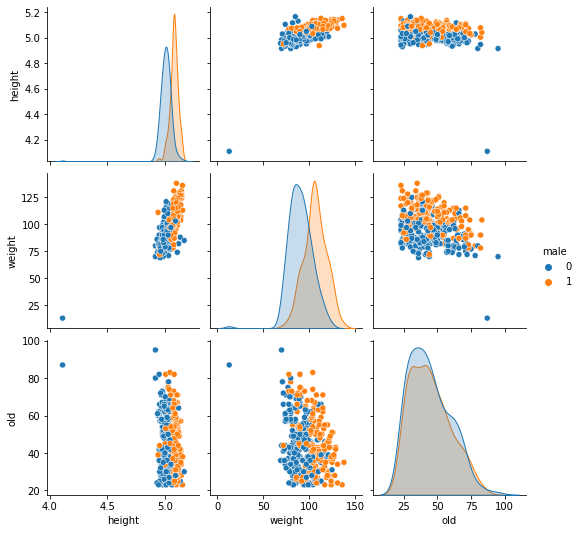

In [7]:
sns.pairplot(howell_df[howell_df['old']!=0].drop(columns='young'), hue="male");

In [114]:
# Removing outliers
howell_df = howell_df[
    ((howell_df["young"] >= 0) |
    ((howell_df["old"] != 0) & howell_df["weight"] > 50))
    ]
howell_df.drop(index=2693, inplace=True)

In [192]:
regressor_matrix = tf.constant(howell_df.drop(columns="height"), dtype=tf.float32)
regressor_matrix = tf.concat([tf.ones(len(regressor_matrix), tf.float32)[...,tf.newaxis],regressor_matrix],axis=1)
response = tf.cast(howell_df["height"], dtype=tf.float32)

@tf.function(autograph=False)
def fit_model(scale=1.0):
    model_coefficients, linear_response, is_converged, num_iter = tfp.glm.fit(
        model_matrix=regressor_matrix,
        response=response,
        model=tfp.glm.Normal(scale=scale)
    )
    log_likelihood = tfp.glm.Normal(scale=scale).log_prob(response, linear_response)
    return (model_coefficients, linear_response, is_converged, num_iter, log_likelihood)

In [193]:
# Fit the model
model_coefficients, linear_response, is_converged, num_iter, log_likelihood = fit_model()

In [194]:
print(('is_converged: {}\n'
       '    num_iter: {}\n'
       '    accuracy: {}\n'
       '    deviance: {}\n'
      ).format(
    is_converged,
    num_iter,
    pd.np.mean(pd.np.abs(linear_response  - howell_df['height']) <= 0.1),
    2. * pd.np.mean(log_likelihood)
    ))

is_converged: True
    num_iter: 2
    accuracy: 0.8071519795657727
    deviance: -1.8465293645858765



In [195]:
predictions_df = pd.DataFrame({"observed":howell_df["height"],
            "fitted":linear_response,
            "age": np.where(howell_df["young"] > 0, "young", "old")})

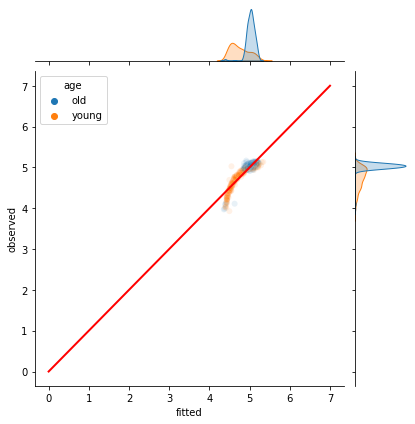

In [196]:
plot = sns.jointplot(x="fitted", 
              y="observed", 
              hue="age",
              data=predictions_df, joint_kws=dict(alpha=0.1))
# Plotting the line observed = fitted
plot.ax_joint.plot([0,7], [0,7], 'r', linewidth = 2);

## Custom distributions

In [197]:
regressor_matrix = tf.constant(howell_df.drop(columns="height"), dtype=tf.float32)
regressor_matrix = tf.concat([tf.ones(len(regressor_matrix), tf.float32)[...,tf.newaxis],regressor_matrix],axis=1)
response = tf.cast(howell_df["height"], dtype=tf.float32)

@tf.function(autograph=False)
def fit_model_t(scale=1.0):
    custom_glm = tfp.glm.CustomExponentialFamily(lambda mean: tfp.distributions.StudentT(len(response)+1, mean, scale), tf.identity)
    model_coefficients, linear_response, is_converged, num_iter = tfp.glm.fit(
        model_matrix=regressor_matrix,
        response=response,
        model=custom_glm,
        l2_regularizer=tf.constant(1.0),
        l2_regularization_penalty_factor=tf.constant([1., 1., 1., 1., 1e-10]),
        dispersion=tf.constant([0.1])
    )
    log_likelihood = custom_glm.log_prob(response, linear_response)
    return (model_coefficients, linear_response, is_converged, num_iter, log_likelihood)

In [198]:
model_coefficients, linear_response, is_converged, num_iter, log_likelihood = fit_model_t()

In [199]:
print(('is_converged: {}\n'
       '    num_iter: {}\n'
       '    accuracy: {}\n'
       '    deviance: {}\n'

      ).format(
    is_converged,
    num_iter,
    pd.np.mean(pd.np.abs(linear_response  - howell_df['height']) <= 0.1),
    2. * pd.np.mean(log_likelihood)
    ))

is_converged: True
    num_iter: 2
    accuracy: 0.8020434227330779
    deviance: -1.8471804857254028



In [200]:
predictions_df = pd.DataFrame({"observed":howell_df["height"],
            "fitted":linear_response,
            "age": np.where(howell_df["young"] > 0, "young", "old")})

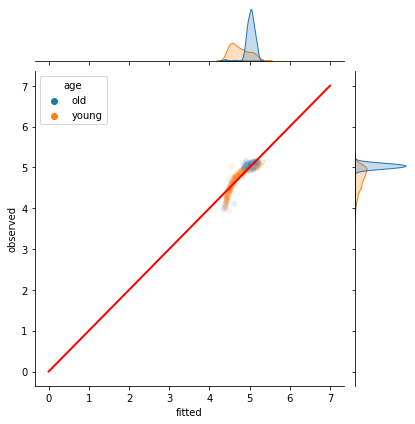

In [201]:
plot = sns.jointplot(x="fitted", 
              y="observed",
              hue="age",
              data=predictions_df, joint_kws=dict(alpha=0.1))
#
#  Plotting the line observed = fitted
plot.ax_joint.plot([0,7], [0,7], 'r', linewidth = 2);